In [1]:
import math
import sys

sys.path.append("../")

import IPython
import matplotlib.pylab as plt
import numpy as np

from constants import SPEED_OF_SOUND

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
out_dir = 'Output'

Fs = 32000
gt_elevation = None
dimension = 2
baseline = 0.1  # 15
distance = 0.5  # distance of source

gt_azimuth = 30 * np.pi / 180.0

duration = 0.1  # seconds
times = np.arange(0, duration, step=1 / Fs)
added_noise_std = 1e-2  #

frequency = 200

In [3]:
from mic_array import get_square_array, get_uniform_array, ambiguity_test

source = distance * np.array([np.cos(gt_azimuth), np.sin(gt_azimuth)]).reshape((1, -1))
mic_positions = get_uniform_array(mic_number=4, dimension=dimension, baseline=baseline)
mic_ref = mic_positions[0]
ambiguity_test(mic_positions, frequency)

from signals import MonoSignal

# ambiguity test

# find exact delays at different mics
from algos_basics import get_mic_delta

np.random.seed(1)

delays = [
    get_mic_delta(mic_ref, mic_other, source) / SPEED_OF_SOUND
    for mic_other in mic_positions
]

source_signal = MonoSignal(f=frequency)
signals = np.array(
    [source_signal.evaluate(times + d, noise=0) for d in delays], dtype=np.float
)

if added_noise_std > 0:
    signals += np.random.normal(loc=0, scale=added_noise_std, size=signals.shape)

signal wavelength/2: 8.2e-01, minimum distance between mics 3.3e-02
signal wavelength is 49.5 times bigger than minimum mic distance. (Make sure it is more than 1)


In [4]:
start_idx = 100
buffer_length = 32  # 512
n_mics = signals.shape[0]
buffer = signals[:, start_idx : start_idx + buffer_length]

saved data as Output/fft_bin_data.c
saved image as Output/fft_bin_data.png


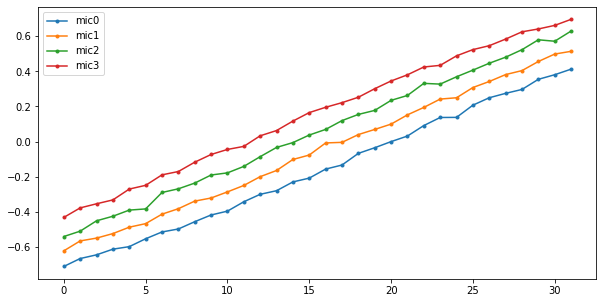

In [5]:
name = "fft_bin_data"

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

fname = f"{out_dir}/{name}.c"
with open(fname, "w") as f:
    for i, signal in enumerate(buffer):
        f.write(f"float32_t mic{i}[{buffer_length}] = " + r"{")
        [f.write(f"{s:.15f}, ",) for s in signal[:-1]]
        [f.write(f"{s:.15f}",) for s in signal[-1:]]
        # np.array_str(signal, precision=15, max_line_width=80))
        f.write(r"};" + " \n\n")

        ax.plot(signal, ".-", label=f"mic{i}", color=f"C{i}")
print("saved data as", fname)
ax.legend()

fname = f"{out_dir}/{name}.png"
fig.savefig(fname)
print("saved image as", fname)

In [6]:
print(buffer[1])

[-0.62268529 -0.56609226 -0.55009878 -0.52429019 -0.48786445 -0.4676852
 -0.41369076 -0.38259982 -0.33929444 -0.32160573 -0.28671952 -0.25007583
 -0.20003131 -0.16484406 -0.1021254  -0.07673065 -0.00780654 -0.00446105
  0.03982852  0.06913524  0.09945815  0.15222129  0.1945996   0.24212102
  0.24967931  0.30802518  0.34233318  0.38173201  0.40437825  0.45630581
  0.49867572  0.5142249 ]


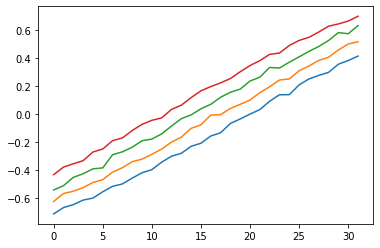

In [7]:
plt.figure()
for i in range(buffer.shape[0]):
    plt.plot(buffer[i])

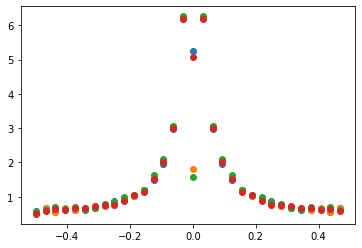

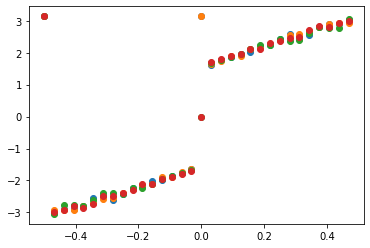

In [8]:
buffer_f = np.fft.fft(buffer, buffer.shape[1], axis=1)
freq = np.fft.fftfreq(buffer.shape[1])
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.scatter(freq, np.abs(buffer_f[i]))
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.scatter(freq, np.angle(buffer_f[i]))

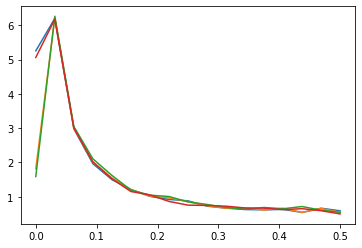

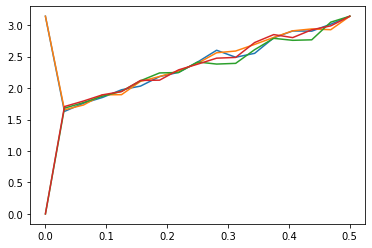

In [9]:
buffer_f = np.fft.rfft(buffer, buffer.shape[1], axis=1)
freq = np.fft.rfftfreq(buffer.shape[1])
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.plot(freq, np.abs(buffer_f[i]))
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.plot(freq, np.angle(buffer_f[i]))

In [10]:
print(buffer.shape)
print(buffer_f.shape)
idx = 1
for real, imag in zip(buffer_f[idx, :].real, buffer_f[idx, :].imag):
    print(real, end=", ")
    print(imag)
#print(buffer_f)

(4, 32)
(4, 17)
-1.8159830922815923, 0.0
-0.5254221152788747, 6.201136159834501
-0.47859356561957656, 2.9654118069956423
-0.6374087610541319, 1.9131095354719285
-0.4933507293876017, 1.466958482340874
-0.6164359500551668, 1.0373810392687182
-0.5866075620090291, 0.8344412930539283
-0.6253900413100468, 0.7384333327775482
-0.626968881869001, 0.5816526983411654
-0.6161858510160734, 0.4040887086479702
-0.565513671581643, 0.34901852269602884
-0.6074447994983896, 0.2916394669266502
-0.5787444707893729, 0.20272696798670864
-0.6465546855398596, 0.15253538861654115
-0.5327920315493626, 0.1089760649874878
-0.6441878041402034, 0.14016895143430164
-0.5467444200297908, 0.0


In [11]:
vectf = np.empty((buffer_f.shape[1], buffer_f.shape[0]*2))
for f in range(buffer_f.shape[1]):
    m = 0
    for mic in range(buffer_f.shape[0]):
        vectf[f, m] = buffer_f[mic, f].real
        vectf[f, m+1] = buffer_f[mic, f].imag
        m += 2
print('freq 0:', vectf[0])
print(vectf[:, 2:4].flatten())

print(buffer_f.shape)
for f in range(buffer_f.shape[1]):
    Rx = np.outer(buffer_f[:, f].conj(),  buffer_f[:, f])
 
    for i in range(Rx.shape[0]):
        for j in range(Rx.shape[1]):
            print(np.round(Rx[i, j].real, 5), end=",")
            print(np.round(Rx[i, j].imag, 5), end=",")
        print()
    print()
    break

freq 0: [-5.253824    0.         -1.81598309  0.          1.58883357  0.
  5.060624    0.        ]
[-1.81598309  0.         -0.52542212  6.20113616 -0.47859357  2.96541181
 -0.63740876  1.91310954 -0.49335073  1.46695848 -0.61643595  1.03738104
 -0.58660756  0.83444129 -0.62539004  0.73843333 -0.62696888  0.5816527
 -0.61618585  0.40408871 -0.56551367  0.34901852 -0.6074448   0.29163947
 -0.57874447  0.20272697 -0.64655469  0.15253539 -0.53279203  0.10897606
 -0.6441878   0.14016895 -0.54674442  0.        ]
(4, 17)
27.60267,0.0,9.54086,0.0,-8.34745,-0.0,-26.58763,-0.0,
9.54086,0.0,3.29779,0.0,-2.88529,-0.0,-9.19001,-0.0,
-8.34745,0.0,-2.88529,0.0,2.52439,0.0,8.04049,0.0,
-26.58763,0.0,-9.19001,0.0,8.04049,0.0,25.60992,0.0,



In [12]:
np.random.seed(1)
real = np.random.choice(9, size=9).reshape((3, 3))
imag = np.random.randint(9, size=9).reshape((3, 3))
compl = real + 1j*imag
print(compl)

[[5.+4.j 8.+5.j 5.+2.j]
 [0.+4.j 0.+2.j 1.+4.j]
 [7.+7.j 6.+7.j 2.+1.j]]


In [13]:
compl_inv = np.linalg.inv(compl)
print(compl_inv)

[[-0.172841  +0.06576197j  0.06291461-0.14924424j  0.11722655-0.1013843j ]
 [ 0.15893739-0.07466756j -0.03734892+0.21137128j -0.02577772+0.00963257j]
 [ 0.09456881-0.00478599j  0.00693666-0.20470724j -0.12092206+0.0663375j ]]


In [14]:
np.testing.assert_allclose(compl_inv.dot(compl), np.eye(3), atol=1e-10)
np.testing.assert_allclose(compl.dot(compl_inv), np.eye(3), atol=1e-10)

In [51]:
vect_Xf = np.array([-5.253,-0.59, -4.108,-0.646, 6.035,-0.536, 7.132, -0.578])
vect_Xf_compl = vect_Xf[::2] + 1j*vect_Xf[1::2]

print(vect_Xf_compl)

lamda = 0.01
R = vect_Xf_compl.reshape((-1, 1)).dot(vect_Xf_compl.conj().reshape((1, -1)))
A = R.real + lamda * np.eye(R.shape[0])
B = R.imag + lamda * np.eye(R.shape[0])

[-5.253-0.59j  -4.108-0.646j  6.035-0.536j  7.132-0.578j]


In [47]:
print(A)
print(np.linalg.inv(A))

[[ 27.952109  21.960464 -31.385615 -37.123376]
 [ 21.960464  17.30298  -24.445524 -28.924868]
 [-31.385615 -24.445524  36.718521  43.351428]
 [-37.123376 -28.924868  43.351428  51.209508]]
[[ 48.00817016 -49.42431342   2.09739341   5.11054726]
 [-49.42431342  52.01978492  -4.55937196  -2.58695462]
 [  2.09739341  -4.55937196  56.82572024 -49.16065641]
 [  5.11054726  -2.58695462 -49.16065641  43.88009553]]


In [45]:
print(B)
print(np.linalg.matrix_rank(B))
print(np.linalg.inv(B))

[[ 0.01     -0.969718 -6.376258 -7.244114]
 [ 0.969718  0.01     -6.100498 -6.981696]
 [ 6.376258  6.100498  0.01     -0.334522]
 [ 7.244114  6.981696  0.334522  0.01    ]]
4
[[ 47.77901519 -49.66231372   1.9740669    4.98245742]
 [-49.67307961  51.76116536  -4.69490351  -2.72788182]
 [  1.90327715  -4.76263175  56.71039701 -49.28149193]
 [  4.90203266  -2.80539319 -49.28520582  43.74953346]]


In [50]:
print(np.linalg.inv(A+1j*B))

[[ 39.5083154 -39.5067394j   -7.88153672 +8.61104819j
   14.17916272 -9.39226704j  16.65948437-11.22113937j]
 [ -8.60986426 +7.88283004j  43.50684331-43.50586795j
   11.46974421 -6.88955701j  13.48256668 -8.24083913j]
 [  9.39013718-14.18057331j   6.88783414-11.47077891j
   36.21670882-36.21463838j -16.15194053+16.40561672j]
 [ 11.21863694-16.66116963j   8.23881392-13.48380432j
  -16.40319047+16.15440452j  30.77564261-30.77275484j]]
